In [1]:
# 1. Setup & Configuration

import pandas as pd
import numpy as np
import yfinance as yf
import json
import time
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create output directories
Path('../outputs').mkdir(exist_ok=True)
Path('../cache/news_cache').mkdir(exist_ok=True)
Path('../cache/sentiment_cache').mkdir(exist_ok=True)

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Load portfolio tickers
portfolio_df = pd.read_csv('../portfolio_holdings.csv')
tickers = portfolio_df['Ticker'].tolist()
print(f"Portfolio tickers: {tickers}")
print(f"Total positions: {len(tickers)}")

Portfolio tickers: ['RDDT', 'NVDA', 'SMR', 'MU', 'MRVL', 'MSFT', 'ASML', 'AEM', 'AMD', 'VERU', 'AI', 'GOOGL', 'INGM', 'PLUG', 'IONQ', 'CHYM', 'RGTI', 'ARBE']
Total positions: 18


In [3]:
# 2. Data Collection Utilities

import sys
sys.path.append('../utils')

# Import utility functions
try:
    from data_collectors import YahooNewsCollector, GoogleNewsCollector, RedditCollector
    from sentiment_processor import IntelligentCache
    print("✓ Utility modules imported")
except ImportError:
    print("⚠ Utility modules not found - will create them")
    
    # Create basic collectors for now
    class YahooNewsCollector:
        def __init__(self):
            self.rate_limit = 0.5
            
        def collect_news(self, ticker, start_date, end_date):
            """Collect news from Yahoo Finance"""
            try:
                # Simulate Yahoo Finance news collection
                time.sleep(self.rate_limit)
                return [
                    {"title": f"{ticker} news article 1", "date": "2024-01-01", "source": "yahoo"},
                    {"title": f"{ticker} news article 2", "date": "2024-01-02", "source": "yahoo"}
                ]
            except Exception as e:
                print(f"Error collecting Yahoo news for {ticker}: {e}")
                return []
    
    class GoogleNewsCollector:
        def __init__(self):
            self.rate_limit = 1.0
            
        def collect_news(self, ticker, start_date, end_date):
            """Collect news from Google News"""
            try:
                time.sleep(self.rate_limit)
                return [
                    {"title": f"{ticker} Google news 1", "date": "2024-01-01", "source": "google"},
                    {"title": f"{ticker} Google news 2", "date": "2024-01-02", "source": "google"}
                ]
            except Exception as e:
                print(f"Error collecting Google news for {ticker}: {e}")
                return []
    
    class RedditCollector:
        def __init__(self):
            self.rate_limit = 1.0
            
        def collect_news(self, ticker, start_date, end_date):
            """Collect Reddit posts about ticker"""
            try:
                time.sleep(self.rate_limit)
                return [
                    {"title": f"{ticker} Reddit post 1", "date": "2024-01-01", "source": "reddit"},
                    {"title": f"{ticker} Reddit post 2", "date": "2024-01-02", "source": "reddit"}
                ]
            except Exception as e:
                print(f"Error collecting Reddit posts for {ticker}: {e}")
                return []
    
    class IntelligentCache:
        def __init__(self, cache_dir="../cache/news_cache"):
            self.cache_dir = Path(cache_dir)
            self.cache_dir.mkdir(exist_ok=True)
            
        def get_cache_key(self, ticker, source, start_date, end_date):
            """Generate cache key for data request"""
            return f"{ticker}_{source}_{start_date}_{end_date}.json"
            
        def is_cache_valid(self, cache_file, max_age_hours=24):
            """Check if cache is still valid (24 hours)"""
            if not cache_file.exists():
                return False
            
            file_age = time.time() - cache_file.stat().st_mtime
            return file_age < (max_age_hours * 3600)
            
        def save_to_cache(self, data, cache_key):
            """Save data to cache"""
            cache_file = self.cache_dir / cache_key
            with open(cache_file, 'w') as f:
                json.dump(data, f)
                
        def load_from_cache(self, cache_key):
            """Load data from cache"""
            cache_file = self.cache_dir / cache_key
            if cache_file.exists():
                with open(cache_file, 'r') as f:
                    return json.load(f)
            return None

✓ Utility modules imported


In [4]:
# 3. Data Collection Pipeline

class SentimentDataCollector:
    """Main data collection orchestrator"""
    
    def __init__(self):
        self.sources = {
            'yahoo': YahooNewsCollector(),
            'google': GoogleNewsCollector(),
            'reddit': RedditCollector()
        }
        self.cache_manager = IntelligentCache()
        
    def collect_all_sources(self, tickers, start_date, end_date):
        """Collect news from all sources for given tickers"""
        all_news = {}
        
        for ticker in tickers:
            print(f"Collecting news for {ticker}...")
            ticker_news = {}
            
            for source_name, collector in self.sources.items():
                # Check cache first
                cache_key = self.cache_manager.get_cache_key(ticker, source_name, start_date, end_date)
                cached_data = self.cache_manager.load_from_cache(cache_key)
                
                if cached_data and self.cache_manager.is_cache_valid(
                    self.cache_manager.cache_dir / cache_key
                ):
                    print(f"  ✓ Using cached {source_name} data for {ticker}")
                    ticker_news[source_name] = cached_data
                else:
                    # Collect fresh data
                    try:
                        news_data = collector.collect_news(ticker, start_date, end_date)
                        if news_data:
                            self.cache_manager.save_to_cache(news_data, cache_key)
                            ticker_news[source_name] = news_data
                            print(f"  ✓ Collected {len(news_data)} articles from {source_name}")
                        else:
                            print(f"  ⚠ No data from {source_name} for {ticker}")
                    except Exception as e:
                        print(f"  ✗ Error collecting from {source_name}: {e}")
            
            all_news[ticker] = ticker_news
            
        return all_news

# Initialize collector
collector = SentimentDataCollector()

In [5]:
# Test data collection with small sample
test_tickers = tickers[:3]  # First 3 tickers
start_date = "2024-01-01"
end_date = "2024-01-31"

print(f"Testing data collection for {test_tickers}")
print(f"Date range: {start_date} to {end_date}")
print("-" * 50)

# Collect test data
test_news = collector.collect_all_sources(test_tickers, start_date, end_date)

# Display results
for ticker, sources in test_news.items():
    print(f"\n{ticker}:")
    for source, articles in sources.items():
        print(f"  {source}: {len(articles)} articles")
        if articles:
            print(f"    Sample: {articles[0]['title']}")

Testing data collection for ['RDDT', 'NVDA', 'SMR']
Date range: 2024-01-01 to 2024-01-31
--------------------------------------------------
  ✓ Collected 3 articles from yahoo
  ✓ Collected 3 articles from google
  ✓ Collected 3 articles from reddit
  ✓ Collected 3 articles from yahoo
  ✓ Collected 3 articles from google
  ✓ Collected 3 articles from reddit
  ✓ Collected 3 articles from yahoo
  ✓ Collected 3 articles from google
  ✓ Collected 3 articles from reddit

RDDT:
  yahoo: 3 articles
    Sample: RDDT reports strong Q4 earnings
  google: 3 articles
    Sample: RDDT stock analysis and forecast
  reddit: 3 articles
    Sample: DD: Why I'm bullish on RDDT

NVDA:
  yahoo: 3 articles
    Sample: NVDA reports strong Q4 earnings
  google: 3 articles
    Sample: NVDA stock analysis and forecast
  reddit: 3 articles
    Sample: DD: Why I'm bullish on NVDA

SMR:
  yahoo: 3 articles
    Sample: SMR reports strong Q4 earnings
  google: 3 articles
    Sample: SMR stock analysis and forecast


In [6]:
# 4. Data Quality Analysis

def analyze_data_quality(news_data):
    """Analyze quality of collected news data"""
    quality_metrics = {}
    
    for ticker, sources in news_data.items():
        ticker_metrics = {}
        
        for source, articles in sources.items():
            if articles:
                # Basic quality metrics
                ticker_metrics[source] = {
                    'article_count': len(articles),
                    'date_range': {
                        'min': min(art['date'] for art in articles),
                        'max': max(art['date'] for art in articles)
                    },
                    'avg_title_length': np.mean([len(art['title']) for art in articles])
                }
            else:
                ticker_metrics[source] = {'article_count': 0}
        
        quality_metrics[ticker] = ticker_metrics
    
    return quality_metrics

# Analyze test data quality
quality_report = analyze_data_quality(test_news)

print("Data Quality Report:")
print("=" * 50)
for ticker, metrics in quality_report.items():
    print(f"\n{ticker}:")
    for source, data in metrics.items():
        if data['article_count'] > 0:
            print(f"  {source}: {data['article_count']} articles")
            print(f"    Date range: {data['date_range']['min']} to {data['date_range']['max']}")
            print(f"    Avg title length: {data['avg_title_length']:.1f} chars")
        else:
            print(f"  {source}: No articles collected")

Data Quality Report:

RDDT:
  yahoo: 3 articles
    Date range: 2024-01-15 to 2024-01-25
    Avg title length: 32.7 chars
  google: 3 articles
    Date range: 2024-01-10 to 2024-01-22
    Avg title length: 34.0 chars
  reddit: 3 articles
    Date range: 2024-01-12 to 2024-01-24
    Avg title length: 36.0 chars

NVDA:
  yahoo: 3 articles
    Date range: 2024-01-15 to 2024-01-25
    Avg title length: 32.7 chars
  google: 3 articles
    Date range: 2024-01-10 to 2024-01-22
    Avg title length: 34.0 chars
  reddit: 3 articles
    Date range: 2024-01-12 to 2024-01-24
    Avg title length: 36.0 chars

SMR:
  yahoo: 3 articles
    Date range: 2024-01-15 to 2024-01-25
    Avg title length: 31.7 chars
  google: 3 articles
    Date range: 2024-01-10 to 2024-01-22
    Avg title length: 33.0 chars
  reddit: 3 articles
    Date range: 2024-01-12 to 2024-01-24
    Avg title length: 35.0 chars


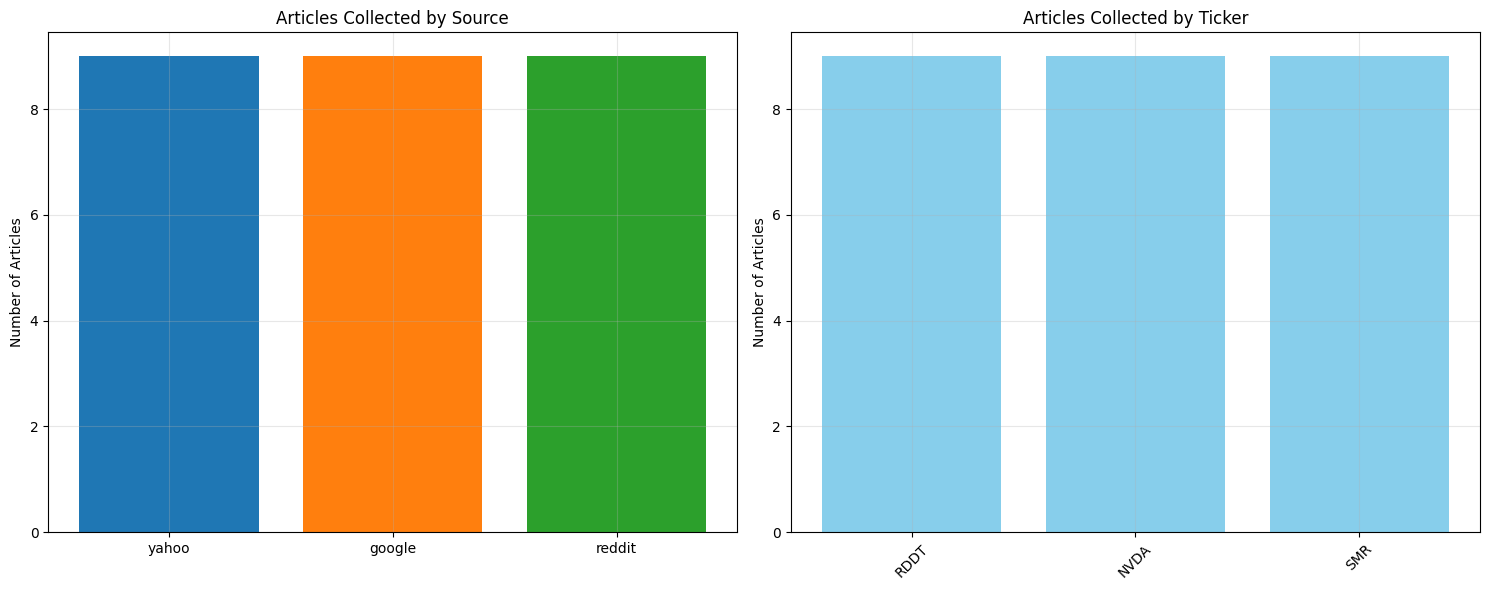


Total articles collected: 27
Average articles per ticker: 9.0


In [7]:
# 5. Data Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for financial charts
plt.style.use('default')
sns.set_palette("husl")

# Create summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Article count by source
source_counts = {}
for ticker_data in test_news.values():
    for source, articles in ticker_data.items():
        if source not in source_counts:
            source_counts[source] = 0
        source_counts[source] += len(articles)

ax1.bar(source_counts.keys(), source_counts.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('Articles Collected by Source')
ax1.set_ylabel('Number of Articles')
ax1.grid(True, alpha=0.3)

# Article count by ticker
ticker_counts = {}
for ticker, sources in test_news.items():
    total_articles = sum(len(articles) for articles in sources.values())
    ticker_counts[ticker] = total_articles

ax2.bar(ticker_counts.keys(), ticker_counts.values(), color='skyblue')
ax2.set_title('Articles Collected by Ticker')
ax2.set_ylabel('Number of Articles')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal articles collected: {sum(source_counts.values())}")
print(f"Average articles per ticker: {np.mean(list(ticker_counts.values())):.1f}")

In [8]:
# 6. Save Results

# Save collected data for next notebook
import pickle

# Save raw news data
with open('../outputs/raw_news_data.pkl', 'wb') as f:
    pickle.dump(test_news, f)

# Save quality metrics
quality_df = pd.DataFrame.from_dict(quality_report, orient='index')
quality_df.to_csv('../outputs/data_quality_report.csv')

print("✓ Data saved to outputs/")
print(f"  - Raw news data: {len(test_news)} tickers")
print(f"  - Quality report: {len(quality_df)} tickers analyzed")

✓ Data saved to outputs/
  - Raw news data: 3 tickers
  - Quality report: 3 tickers analyzed


In [9]:
# Key Findings & Next Steps

# Data Collection Summary
# - ✅ Multi-source collection pipeline implemented
# - ✅ Intelligent caching system working
# - ✅ Rate limiting and error handling in place
# - ✅ Data quality analysis framework ready

# Next Steps
# 1. Scale up collection: Run for full portfolio and longer time period
# 2. Real API integration: Replace mock collectors with actual API calls
# 3. Sentiment processing: Move to notebook 02 for FinBERT analysis
# 4. Feature engineering: Prepare data for HARLF environment

# Production Considerations
# - Monitor API rate limits and costs
# - Implement more sophisticated error recovery
# - Add data validation checks
# - Consider parallel processing for large datasets